<a href="https://colab.research.google.com/github/nicorunini/CCMACLRL_EXERCISES_COM232/blob/main/Exercise3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 3

Use logistic regression to predict the probability of a passenger surviving.

https://www.kaggle.com/competitions/titanic/overview

In [104]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler


In [105]:
train_url = "https://github.com/robitussin/CCMACLRL_EXERCISES_OLD/blob/f5fdfba1aabbbafcf2fe49ca6e1c8f92f69d1458/datasets/titanic/train.csv?raw=true"
test_url  = "https://github.com/robitussin/CCMACLRL_EXERCISES_OLD/blob/f5fdfba1aabbbafcf2fe49ca6e1c8f92f69d1458/datasets/titanic/test.csv?raw=true"
sample_submission_url = "https://github.com/robitussin/CCMACLRL_EXERCISES_OLD/blob/f5fdfba1aabbbafcf2fe49ca6e1c8f92f69d1458/datasets/titanic/gender_submission.csv?raw=true"

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)
sample_sub = pd.read_csv(sample_submission_url)

In [106]:
def preprocess_titanic(df, is_train=True, reference_columns=None):
    data = df.copy()

    # Keep PassengerId for later use
    passenger_id = data['PassengerId'] if 'PassengerId' in data.columns else None

    # Fill missing values
    data['Age'] = data['Age'].fillna(data['Age'].median())
    data['Fare'] = data['Fare'].fillna(data['Fare'].median())
    if 'Embarked' in data.columns:
        data['Embarked'] = data['Embarked'].fillna(data['Embarked'].mode()[0])
    if 'Cabin' in data.columns:
        data['Cabin'] = data['Cabin'].fillna('Unknown')

    # Extract Title from Name
    if 'Name' in data.columns:
        data['Title'] = data['Name'].str.extract(r',\s*([^\.]+)\.')[0].str.strip()
        common_titles = ['Mr', 'Mrs', 'Miss', 'Master']
        data['Title'] = data['Title'].apply(lambda t: t if t in common_titles else 'Other')

    # Extract Deck from Cabin (first letter)
    data['Deck'] = data['Cabin'].apply(lambda x: x[0] if pd.notnull(x) else 'U')

    # Create FamilySize and IsAlone
    data['FamilySize'] = data['SibSp'] + data['Parch'] + 1
    data['IsAlone'] = (data['FamilySize'] == 1).astype(int)

    # Encode Sex
    data['Sex'] = data['Sex'].map({'male': 0, 'female': 1}).astype(int)

    # Convert Pclass to string for one-hot encoding
    data['Pclass'] = data['Pclass'].astype(str)

    # Select features
    features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
                'Embarked', 'Title', 'Deck', 'FamilySize', 'IsAlone']
    proc = data[features].copy()

    # One-hot encode categorical columns
    proc = pd.get_dummies(proc, columns=['Pclass', 'Embarked', 'Title', 'Deck'], drop_first=True)

    # Align test to training columns
    if reference_columns is not None:
        for col in reference_columns:
            if col not in proc.columns:
                proc[col] = 0
        proc = proc[reference_columns]

    if is_train:
        y = data['Survived']
        return proc, y
    else:
        return proc, passenger_id

In [107]:
X_all, y_all = preprocess_titanic(train, is_train=True)

In [108]:
X_train, X_val, y_train, y_val = train_test_split(X_all, y_all,
                                                  test_size=0.2,
                                                  stratify=y_all,
                                                  random_state=0)

# Scale numeric features
numeric_cols = ['Age', 'SibSp', 'Parch', 'Fare', 'FamilySize']
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_val[numeric_cols] = scaler.transform(X_val[numeric_cols])

In [109]:
model = LogisticRegression(max_iter=2000, random_state=0)
model.fit(X_train, y_train)

LogisticRegression(max_iter=2000, random_state=0)

In [111]:
X_test_proc, passenger_ids = preprocess_titanic(test, is_train=False, reference_columns=X_all.columns)
X_test_proc[numeric_cols] = scaler.transform(X_test_proc[numeric_cols])

In [112]:
test_preds = model.predict(X_test_proc)

Validation Accuracy: 0.8212
5-Fold CV Accuracy: 0.8238

Confusion Matrix (Numbers):
[[99 11]
 [21 48]]

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       110
           1       0.81      0.70      0.75        69

    accuracy                           0.82       179
   macro avg       0.82      0.80      0.81       179
weighted avg       0.82      0.82      0.82       179

ROC AUC: 0.8613


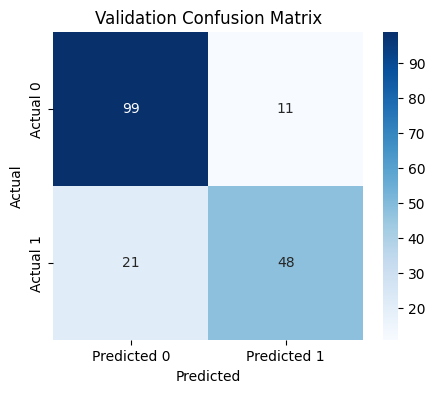

In [116]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

val_acc = model.score(X_val, y_val)
cv_acc = cross_val_score(model, X_all, y_all, cv=5).mean()
y_val_pred = model.predict(X_val)
y_val_prob = model.predict_proba(X_val)[:, 1]

print(f"Validation Accuracy: {val_acc:.4f}")
print(f"5-Fold CV Accuracy: {cv_acc:.4f}")
print("\nConfusion Matrix (Numbers):")
print(confusion_matrix(y_val, y_val_pred))
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))
print(f"ROC AUC: {roc_auc_score(y_val, y_val_prob):.4f}")

# Confusion matrix heatmap
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Validation Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [113]:
submission = pd.DataFrame({
    'PassengerId': passenger_ids,
    'Survived': test_preds
})
submission.to_csv('submission_file.csv', index=False)
print("\nSubmission file saved: submission_file.csv")
print(submission.head())



Submission file saved: submission_file.csv
   PassengerId  Survived
0          892         0
1          893         1
2          894         0
3          895         0
4          896         1
